# h_mean Swing Amplitude Analysis

**Date:** 2025-11-28  
**Crucible:** 3 (lr=1e-3, wd=0.0, 500 steps)  
**Purpose:** Test hypothesis that h_mean oscillation amplitude increases over training

## Hypothesis

Jeffery's prediction (2025-11-28):

1. **Early spike:** h_mean autocorrelation shoots to ~1.0 immediately (observed: steps 0-90)
2. **Plateau:** Stays locked at high autocorrelation for some duration
3. **Declining minimum:** As model gains "confidence," it swings h_mean more assertively
   - `min(autocorr[window])` should decrease over time
   - Larger swings → lower trough values
4. **Stable mean:** Rolling average autocorrelation stays high (oscillating around fixed direction, not random walk)

Metaphor: "Like a first-time auction attendee who's not sure whether he bid or not" → assertive bidder who swings confidently.

## Measurements

1. **Rolling statistics** (windows of 50 steps):
   - Mean autocorrelation (should stay high)
   - Min autocorrelation (should decline?)
   - Std autocorrelation (should increase?)

2. **Angular swing amplitude:**
   - Compute deviation from mean direction in rolling windows
   - Are swings getting bigger in absolute terms?

3. **Early vs Late comparison:**
   - Steps 0-249 vs 250-499
   - Did the distribution change?

Caveat: 500 steps might be too short/noisy to show clear trend. If so, this establishes baseline for Crucible 4 (5000 steps).

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device detection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Plot styling
STEELBLUE = '#4682B4'
CORAL = '#ff6b6b'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'

Using MPS


## Load Data

In [3]:
# Path setup
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
DATA_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-3' / 'crucible_3_trajectory.safetensors'

print(f"Loading data from {DATA_PATH}")

# Load data
data = load_file(str(DATA_PATH))

# Convert h_mean to float32 (stored as float32 in safetensors)
h_mean = data['h_mean'].float()  # (500, 64)

n_steps = h_mean.shape[0]
n_dims = h_mean.shape[1]

print(f"Loaded h_mean: {h_mean.shape}")
print(f"Steps: {n_steps}")
print(f"Dimensions: {n_dims}")

Loading data from /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-3/crucible_3_trajectory.safetensors
Loaded h_mean: torch.Size([500, 64])
Steps: 500
Dimensions: 64


## Compute Autocorrelation

In [4]:
def cosine_similarity(a, b):
    """Cosine similarity between two vectors."""
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

# Compute step-to-step autocorrelation
h_autocorr = torch.zeros(n_steps - 1)
for t in range(n_steps - 1):
    h_autocorr[t] = cosine_similarity(h_mean[t], h_mean[t+1])

print(f"Autocorrelation computed: {h_autocorr.shape}")
print(f"  Mean: {h_autocorr.mean():.6f}")
print(f"  Std:  {h_autocorr.std():.6f}")
print(f"  Min:  {h_autocorr.min():.6f}")
print(f"  Max:  {h_autocorr.max():.6f}")

Autocorrelation computed: torch.Size([499])
  Mean: 0.997557
  Std:  0.016628
  Min:  0.631758
  Max:  0.999984


## Rolling Statistics (Window = 50 steps)

In [5]:
window = 50
n_windows = n_steps - window

rolling_mean = torch.zeros(n_windows)
rolling_min = torch.zeros(n_windows)
rolling_max = torch.zeros(n_windows)
rolling_std = torch.zeros(n_windows)

for i in range(n_windows):
    window_data = h_autocorr[i:i+window]
    rolling_mean[i] = window_data.mean()
    rolling_min[i] = window_data.min()
    rolling_max[i] = window_data.max()
    rolling_std[i] = window_data.std()

print(f"Computed rolling statistics over {n_windows} windows")

Computed rolling statistics over 450 windows


## Plot: Rolling Min Autocorrelation

**Hypothesis:** If swing amplitude increases, the minimum autocorrelation in each window should decline over time.

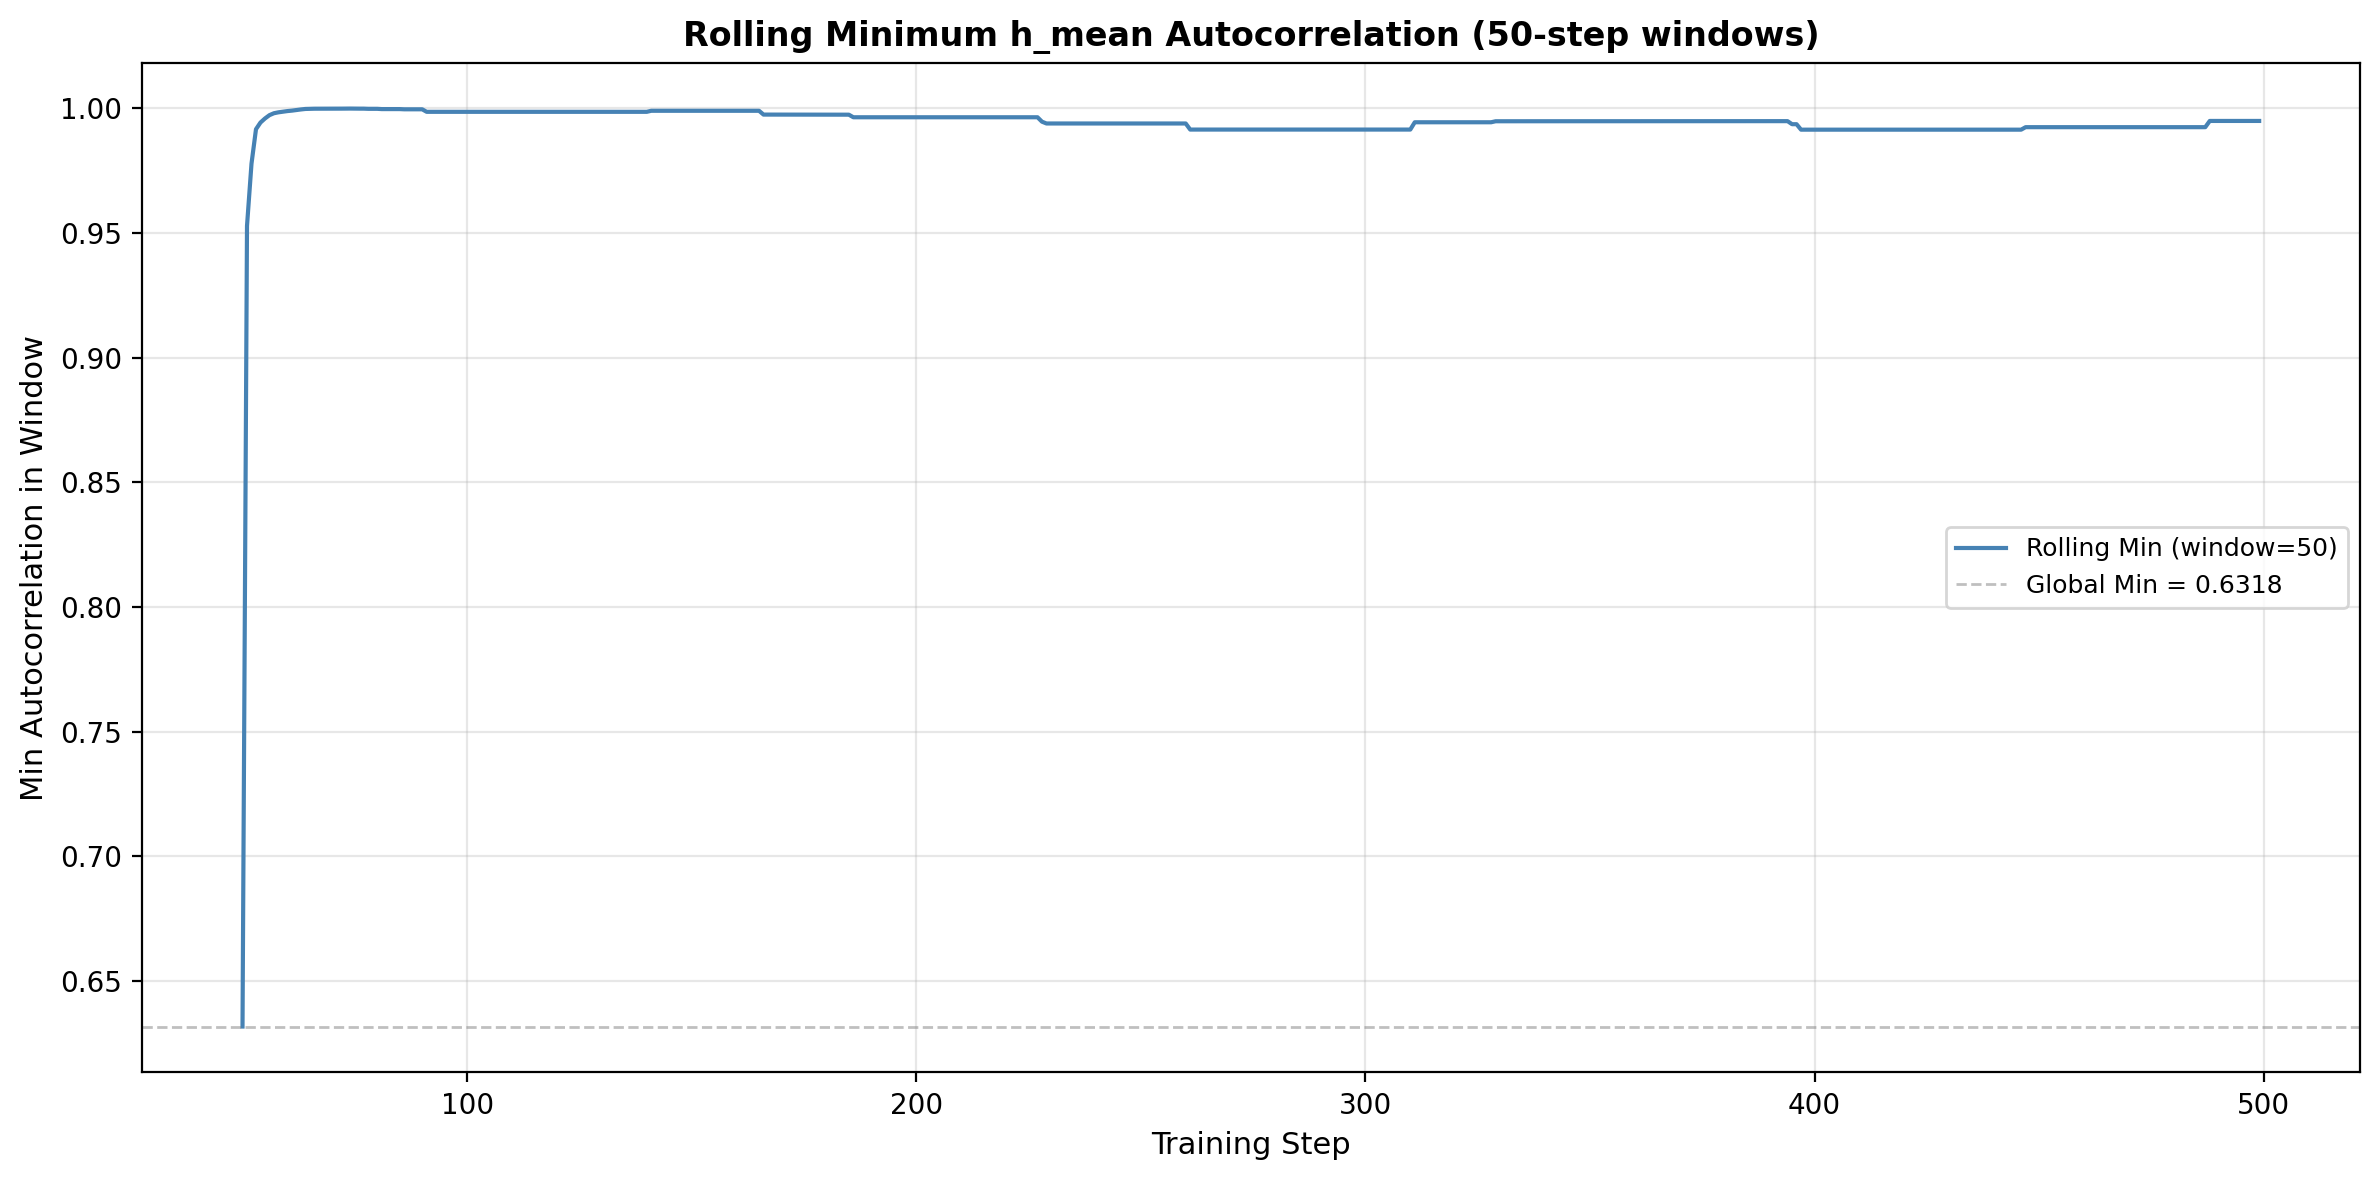

Rolling min range: [0.6318, 0.9999]
Trend: INCREASING
  First window min: 0.6318
  Last window min: 0.9949
  Change: 0.3632


In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(window, n_steps), rolling_min.detach().numpy(), 
        color=STEELBLUE, linewidth=1.5, label='Rolling Min (window=50)')

ax.axhline(y=h_autocorr.min().item(), color='gray', linestyle='--', 
           linewidth=1, alpha=0.5, label=f'Global Min = {h_autocorr.min():.4f}')

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Min Autocorrelation in Window', fontsize=11)
ax.set_title('Rolling Minimum h_mean Autocorrelation (50-step windows)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Rolling min range: [{rolling_min.min():.4f}, {rolling_min.max():.4f}]")
print(f"Trend: {'DECLINING' if rolling_min[-1] < rolling_min[0] else 'INCREASING'}")
print(f"  First window min: {rolling_min[0]:.4f}")
print(f"  Last window min: {rolling_min[-1]:.4f}")
print(f"  Change: {rolling_min[-1] - rolling_min[0]:.4f}")

## Plot: Rolling Std Autocorrelation

**Hypothesis:** If swings get bigger, variance within each window should increase.

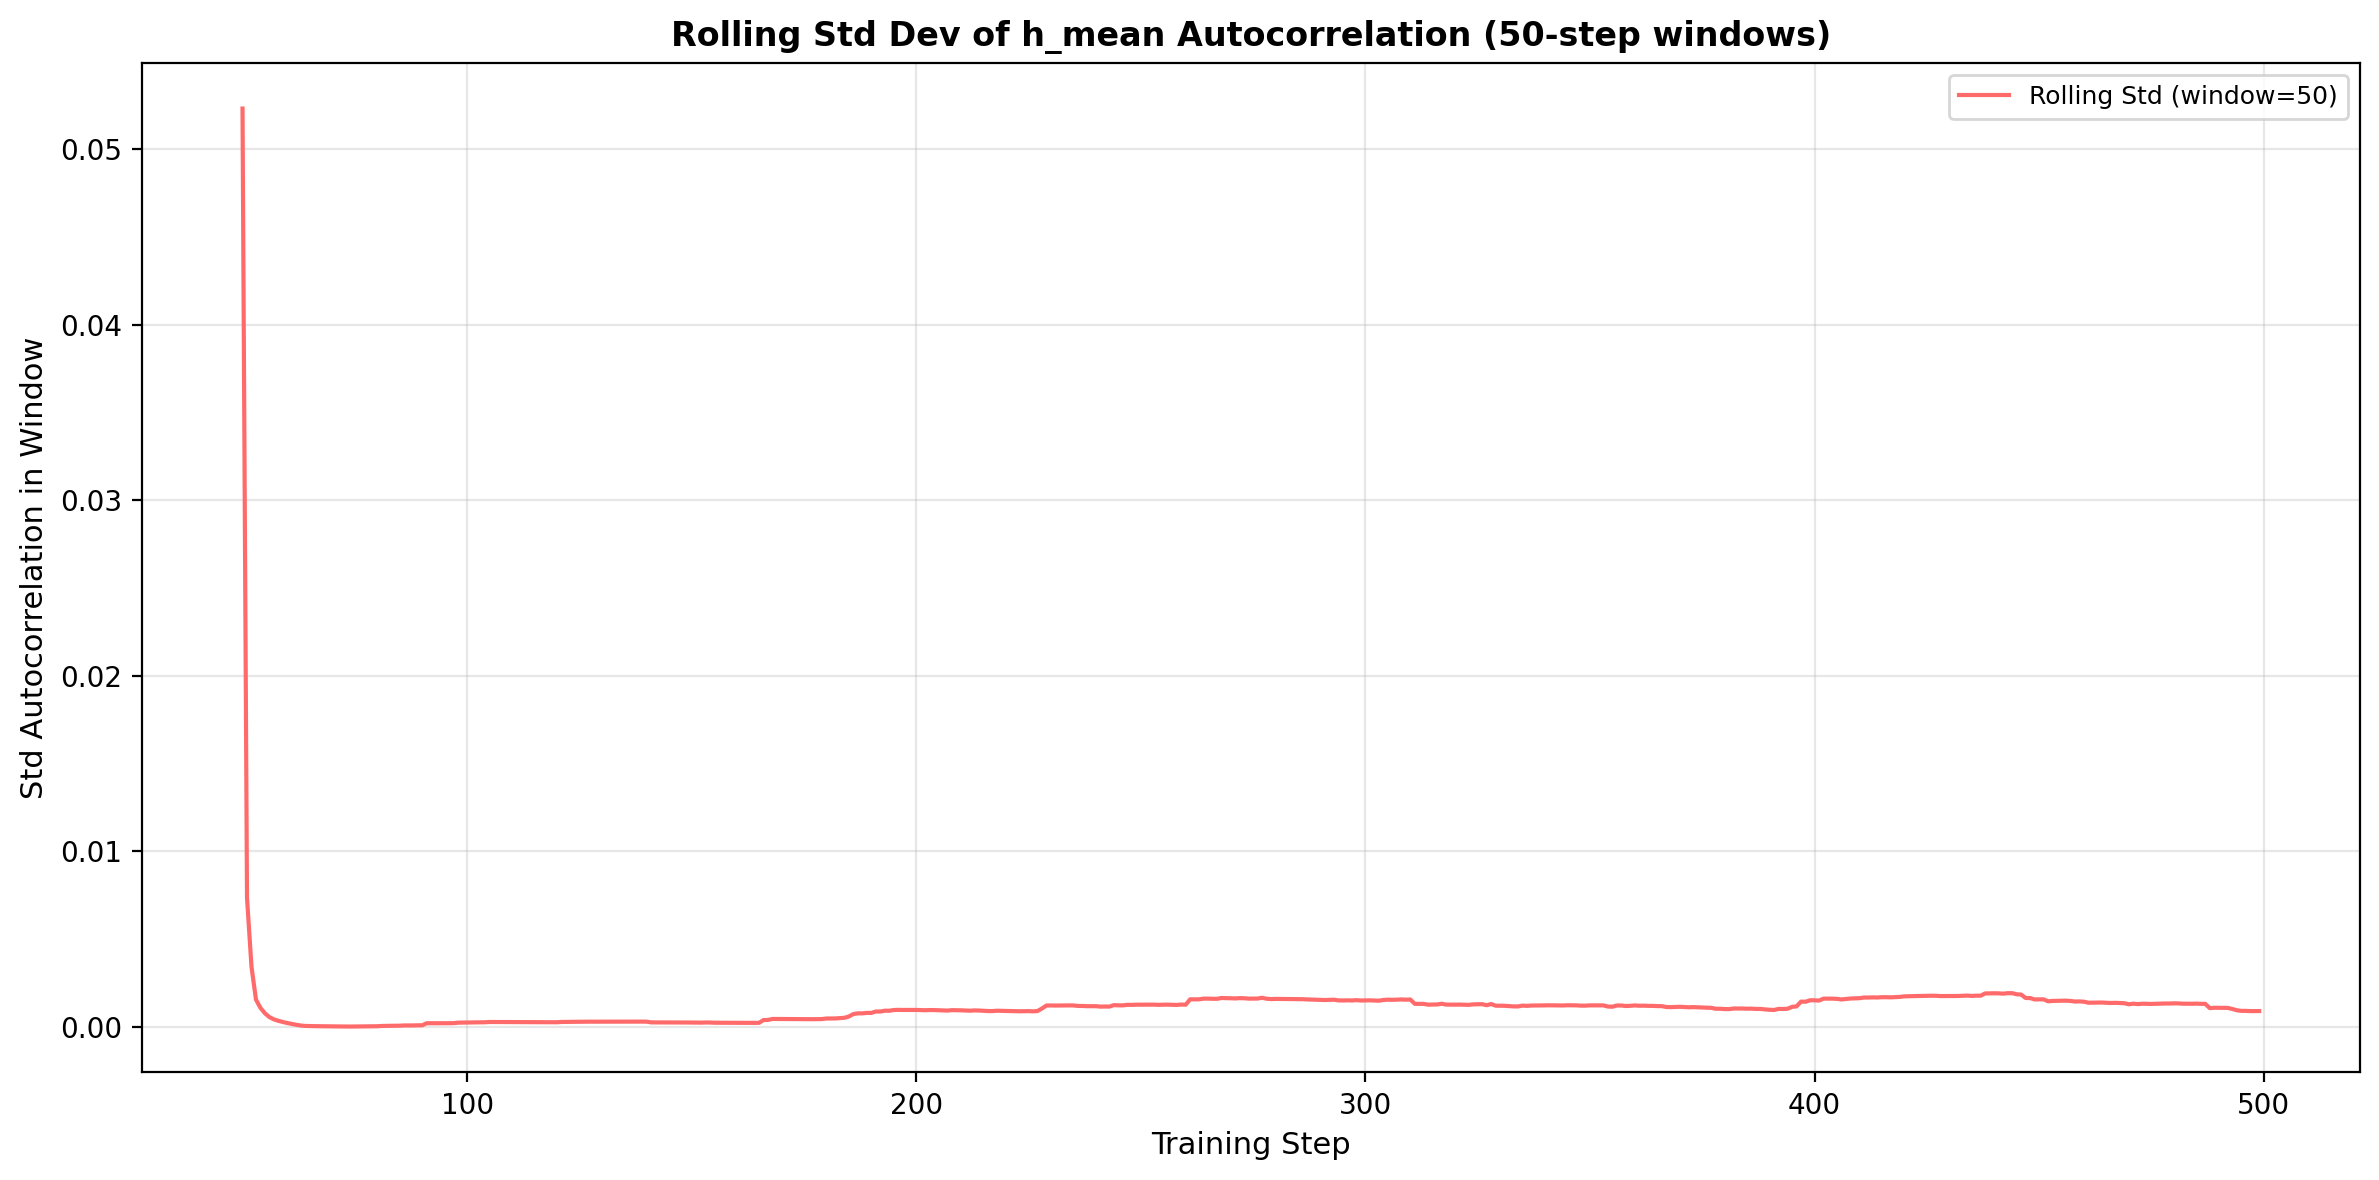

Rolling std range: [0.000020, 0.052305]
Trend: DECREASING
  First window std: 0.052305
  Last window std: 0.000902
  Change: -0.051403


In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(window, n_steps), rolling_std.detach().numpy(), 
        color=CORAL, linewidth=1.5, label='Rolling Std (window=50)')

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Std Autocorrelation in Window', fontsize=11)
ax.set_title('Rolling Std Dev of h_mean Autocorrelation (50-step windows)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Rolling std range: [{rolling_std.min():.6f}, {rolling_std.max():.6f}]")
print(f"Trend: {'INCREASING' if rolling_std[-1] > rolling_std[0] else 'DECREASING'}")
print(f"  First window std: {rolling_std[0]:.6f}")
print(f"  Last window std: {rolling_std[-1]:.6f}")
print(f"  Change: {rolling_std[-1] - rolling_std[0]:.6f}")

## Angular Swing Amplitude

Measure how far h_mean deviates from its mean direction in each window.

For each window:
1. Compute mean direction vector (average of h_mean[t] over window)
2. Measure angular deviation of each h_mean[t] from that mean
3. Report max/mean deviation as "swing amplitude"

In [8]:
swing_amplitude_max = torch.zeros(n_windows)
swing_amplitude_mean = torch.zeros(n_windows)

for i in range(n_windows):
    window_h = h_mean[i:i+window]  # [50, 64]
    
    # Mean direction in this window
    mean_direction = window_h.mean(dim=0)
    mean_direction = mean_direction / torch.norm(mean_direction)  # Normalize
    
    # Angular deviation of each h_mean[t] from mean direction
    deviations = torch.zeros(window)
    for j in range(window):
        h_normalized = window_h[j] / torch.norm(window_h[j])
        cos_theta = torch.dot(h_normalized, mean_direction)
        # Clamp to avoid numerical issues with arccos
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
        deviations[j] = torch.acos(cos_theta)  # Angle in radians
    
    swing_amplitude_max[i] = deviations.max()
    swing_amplitude_mean[i] = deviations.mean()

print(f"Computed angular swing amplitude for {n_windows} windows")

Computed angular swing amplitude for 450 windows


## Plot: Angular Swing Amplitude

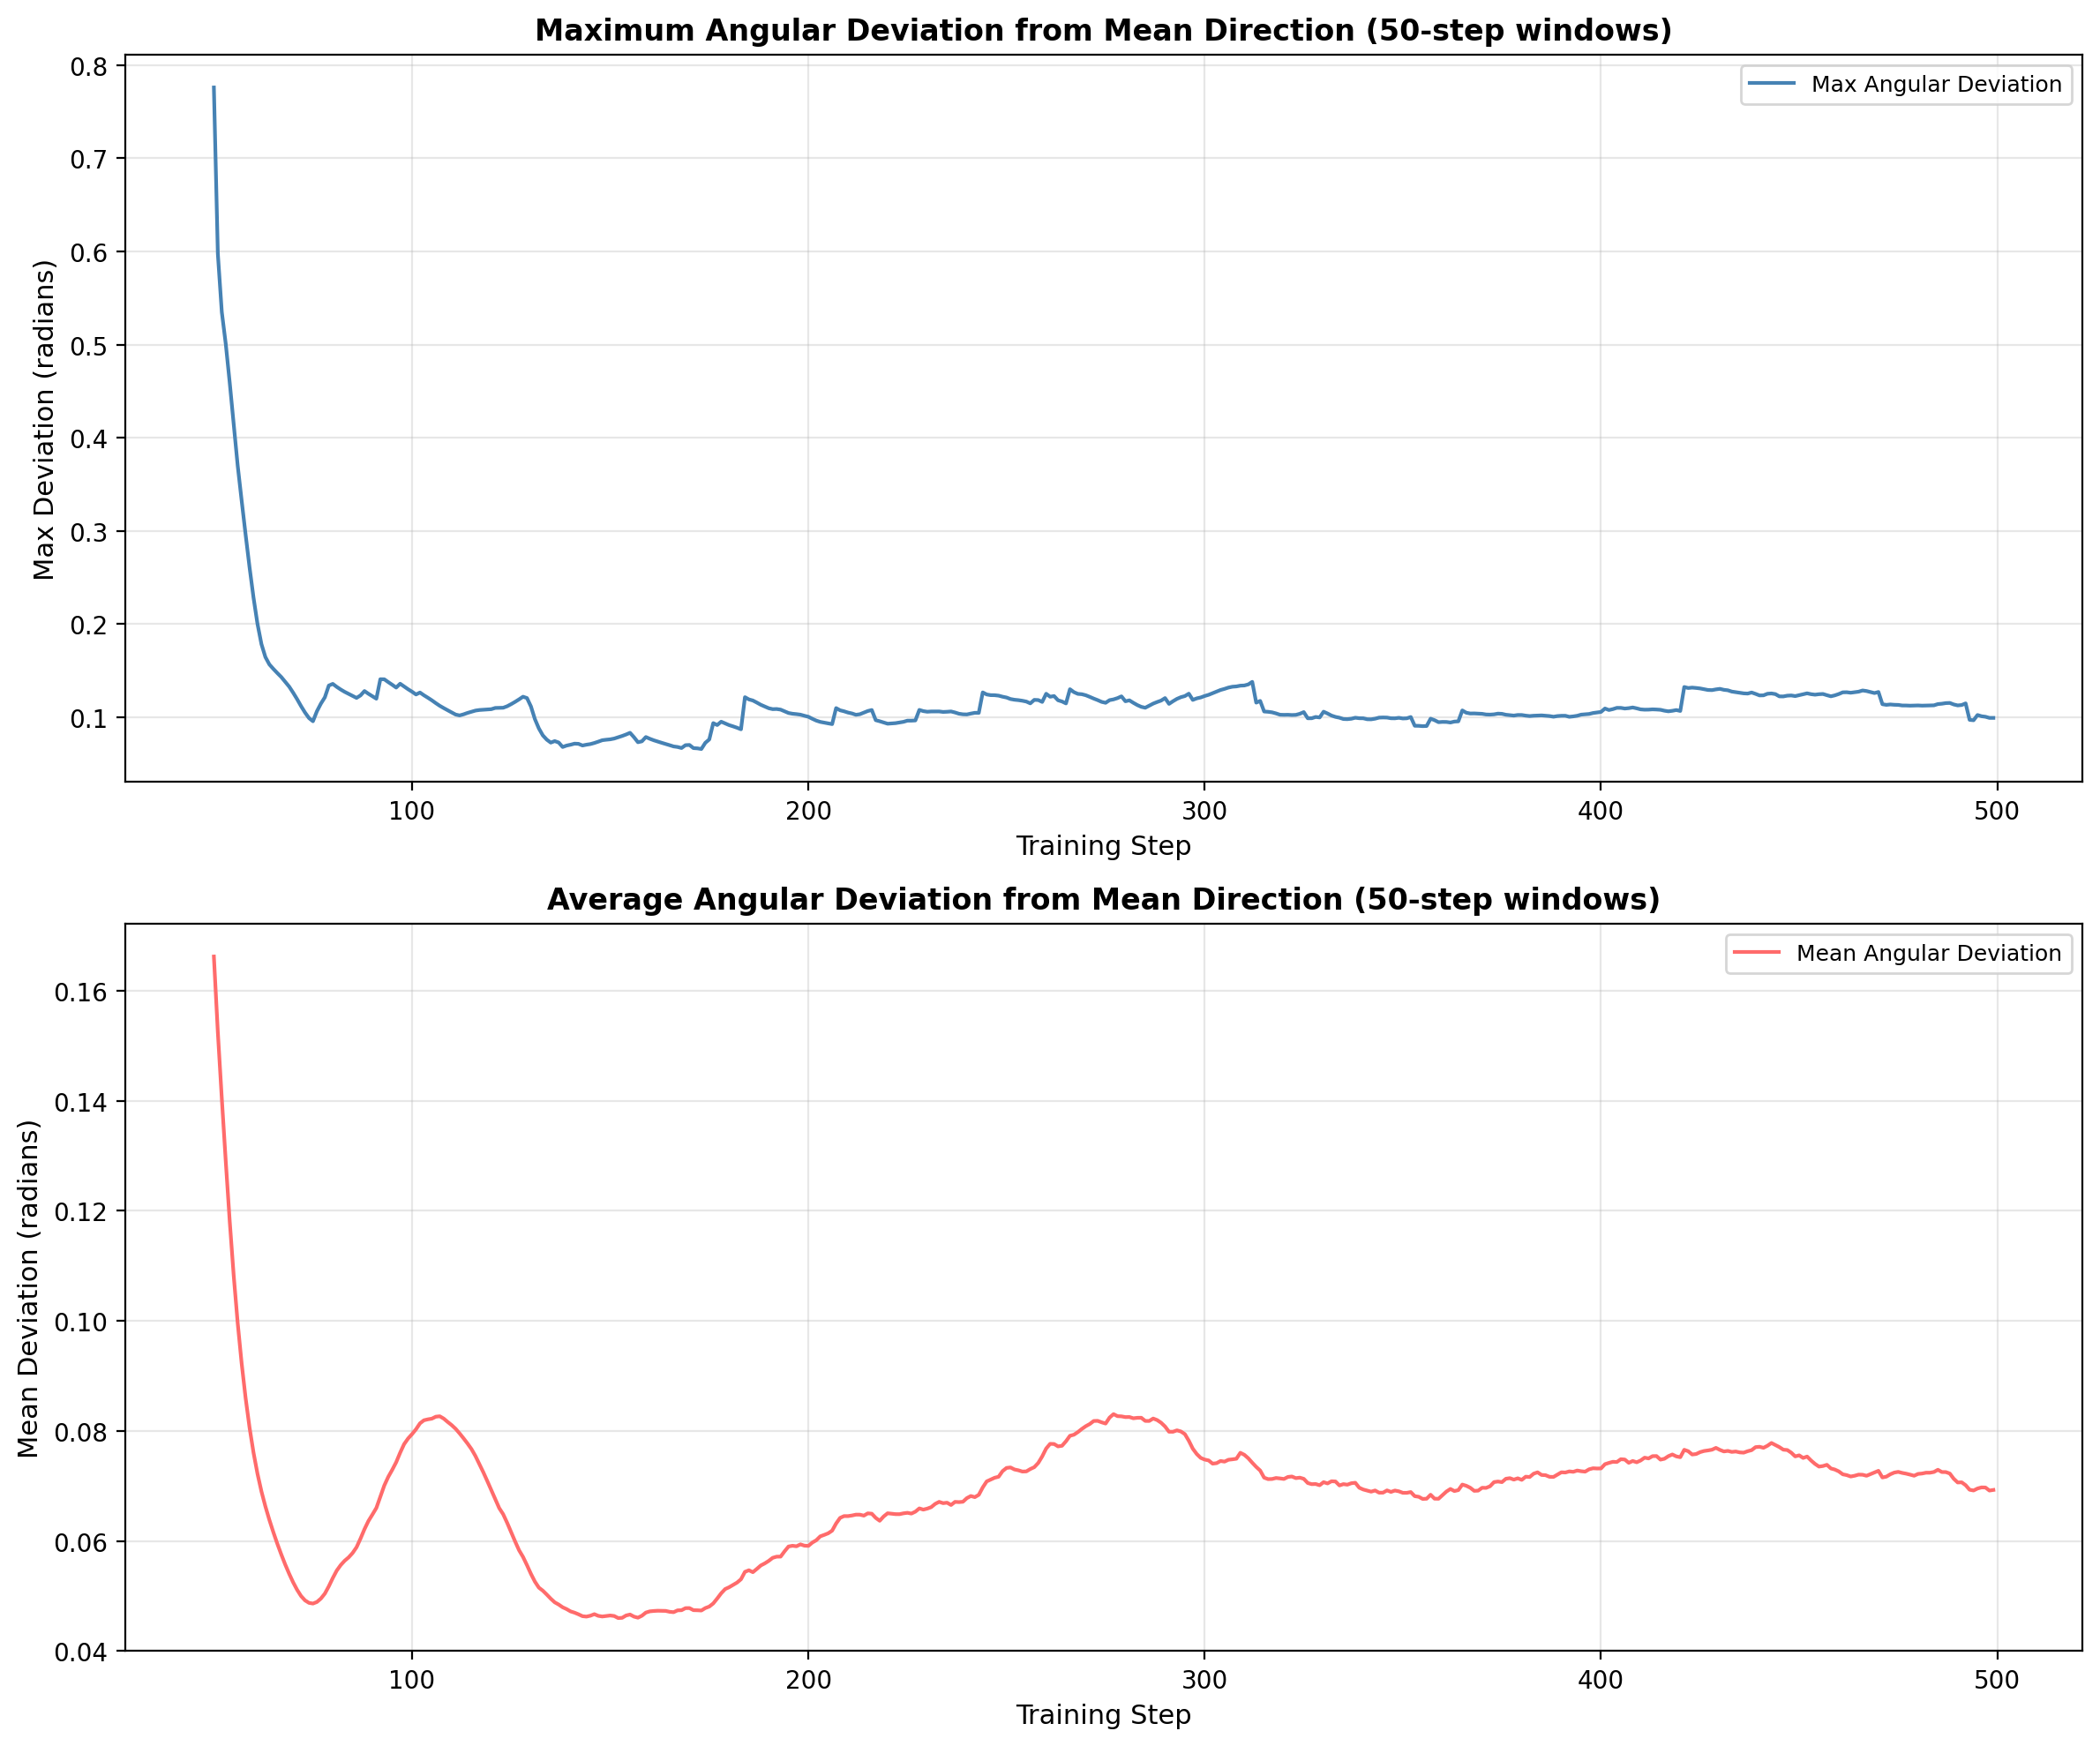

Max swing amplitude range: [0.065746, 0.776063] rad
Mean swing amplitude range: [0.046008, 0.166193] rad
Trend (max): DECREASING
Trend (mean): DECREASING
  First window max: 0.776063 rad
  Last window max: 0.099154 rad
  Change: -0.676909 rad


In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Max deviation
ax1.plot(range(window, n_steps), swing_amplitude_max.detach().numpy(), 
         color=STEELBLUE, linewidth=1.5, label='Max Angular Deviation')
ax1.set_xlabel('Training Step', fontsize=11)
ax1.set_ylabel('Max Deviation (radians)', fontsize=11)
ax1.set_title('Maximum Angular Deviation from Mean Direction (50-step windows)', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Mean deviation
ax2.plot(range(window, n_steps), swing_amplitude_mean.detach().numpy(), 
         color=CORAL, linewidth=1.5, label='Mean Angular Deviation')
ax2.set_xlabel('Training Step', fontsize=11)
ax2.set_ylabel('Mean Deviation (radians)', fontsize=11)
ax2.set_title('Average Angular Deviation from Mean Direction (50-step windows)', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max swing amplitude range: [{swing_amplitude_max.min():.6f}, {swing_amplitude_max.max():.6f}] rad")
print(f"Mean swing amplitude range: [{swing_amplitude_mean.min():.6f}, {swing_amplitude_mean.max():.6f}] rad")
print(f"Trend (max): {'INCREASING' if swing_amplitude_max[-1] > swing_amplitude_max[0] else 'DECREASING'}")
print(f"Trend (mean): {'INCREASING' if swing_amplitude_mean[-1] > swing_amplitude_mean[0] else 'DECREASING'}")
print(f"  First window max: {swing_amplitude_max[0]:.6f} rad")
print(f"  Last window max: {swing_amplitude_max[-1]:.6f} rad")
print(f"  Change: {swing_amplitude_max[-1] - swing_amplitude_max[0]:.6f} rad")

## Early vs Late Comparison

Compare first half (steps 0-249) vs second half (steps 250-499).

In [10]:
midpoint = n_steps // 2

early_autocorr = h_autocorr[:midpoint]
late_autocorr = h_autocorr[midpoint:]

print("=" * 60)
print("EARLY vs LATE COMPARISON")
print("=" * 60)
print(f"\nEarly (steps 0-{midpoint-1}):")
print(f"  Mean: {early_autocorr.mean():.6f}")
print(f"  Std:  {early_autocorr.std():.6f}")
print(f"  Min:  {early_autocorr.min():.6f}")
print(f"  Max:  {early_autocorr.max():.6f}")

print(f"\nLate (steps {midpoint}-{n_steps-1}):")
print(f"  Mean: {late_autocorr.mean():.6f}")
print(f"  Std:  {late_autocorr.std():.6f}")
print(f"  Min:  {late_autocorr.min():.6f}")
print(f"  Max:  {late_autocorr.max():.6f}")

print(f"\nChanges (Late - Early):")
print(f"  Δ Mean: {late_autocorr.mean() - early_autocorr.mean():.6f}")
print(f"  Δ Std:  {late_autocorr.std() - early_autocorr.std():.6f}")
print(f"  Δ Min:  {late_autocorr.min() - early_autocorr.min():.6f}")
print("=" * 60)

EARLY vs LATE COMPARISON

Early (steps 0-249):
  Mean: 0.997483
  Std:  0.023474
  Min:  0.631758
  Max:  0.999984

Late (steps 250-499):
  Mean: 0.997632
  Std:  0.001398
  Min:  0.991439
  Max:  0.999666

Changes (Late - Early):
  Δ Mean: 0.000149
  Δ Std:  -0.022076
  Δ Min:  0.359681


## Histogram: Early vs Late Distribution

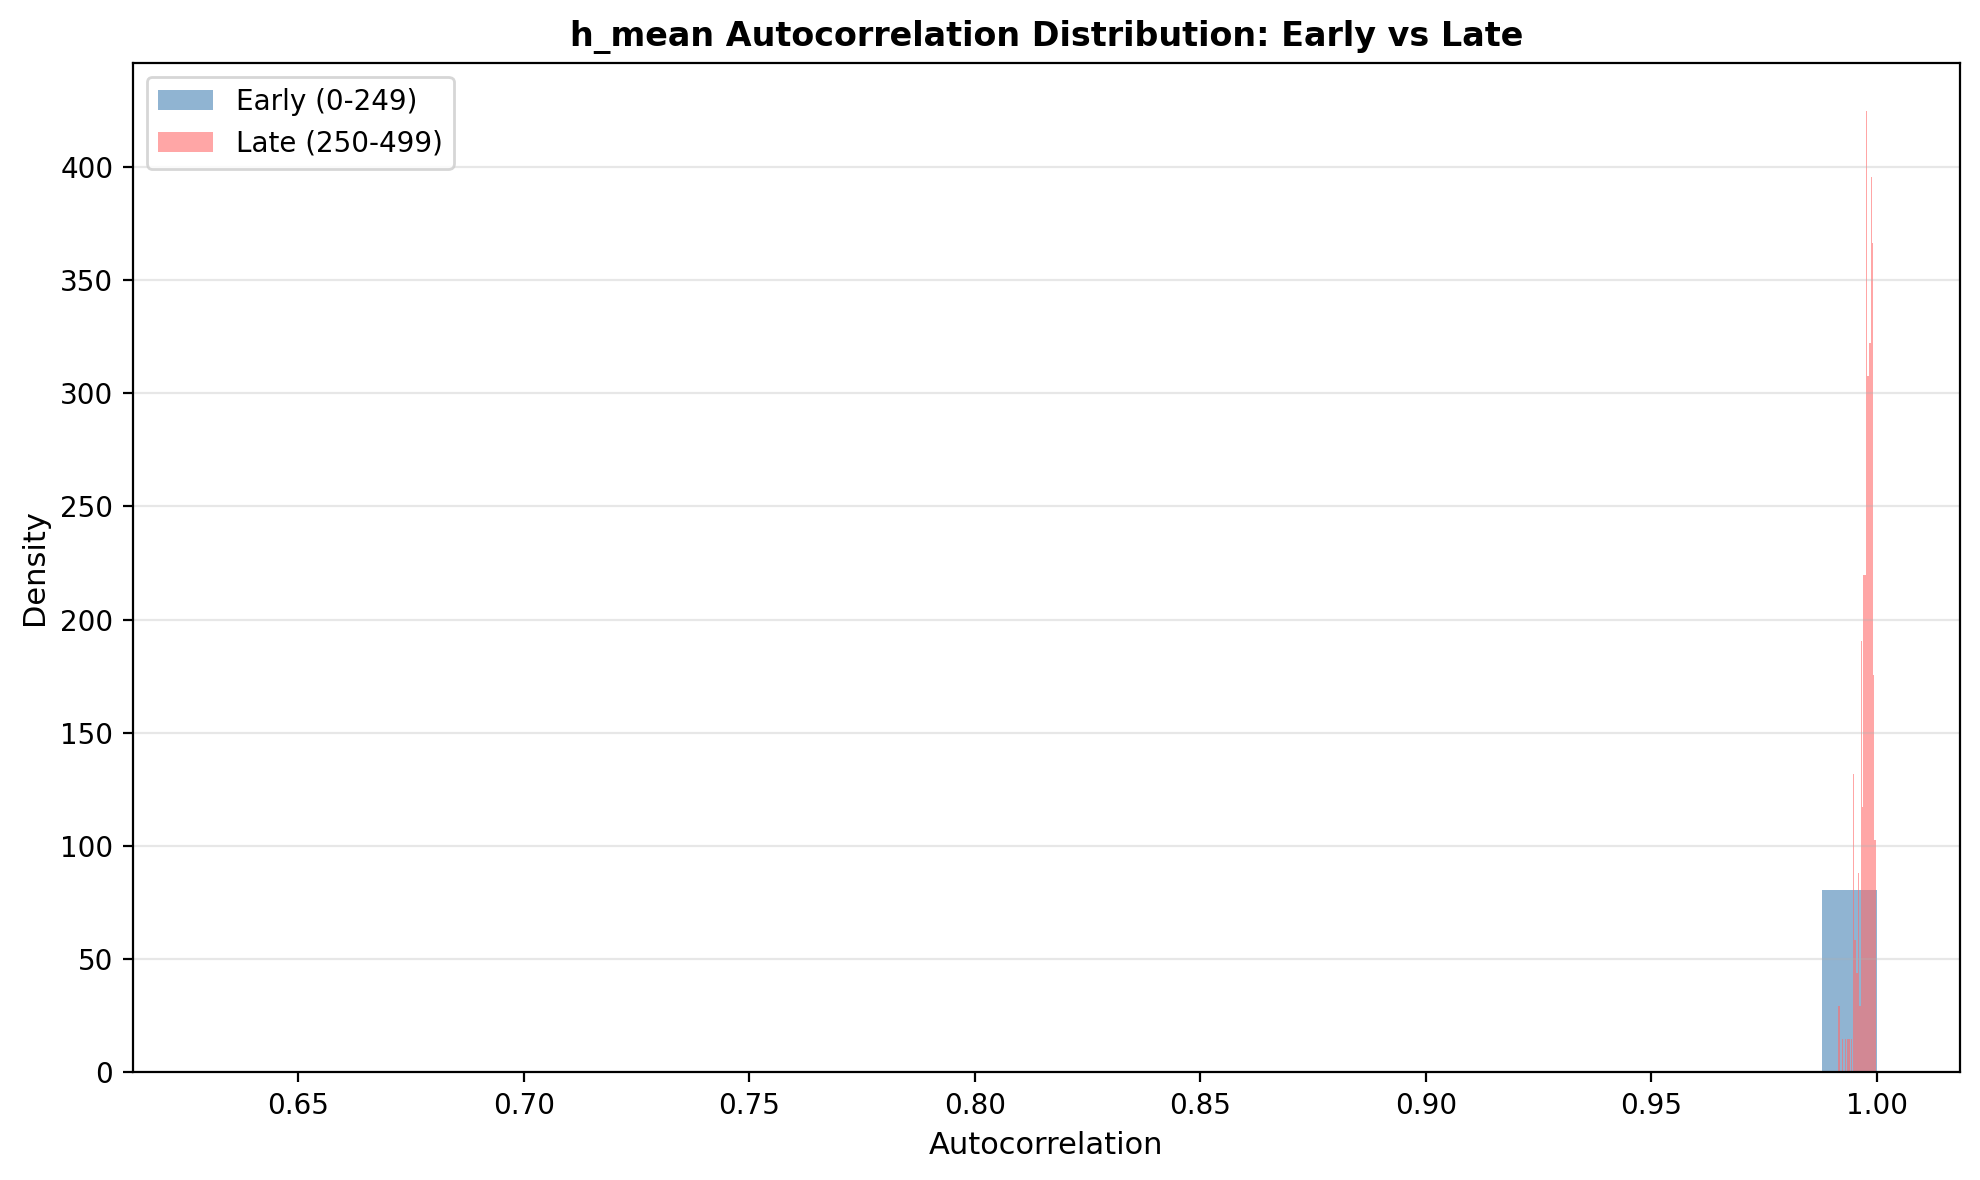

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(early_autocorr.detach().numpy(), bins=30, alpha=0.6, 
        color=STEELBLUE, label=f'Early (0-{midpoint-1})', density=True)
ax.hist(late_autocorr.detach().numpy(), bins=30, alpha=0.6, 
        color=CORAL, label=f'Late ({midpoint}-{n_steps-1})', density=True)

ax.set_xlabel('Autocorrelation', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('h_mean Autocorrelation Distribution: Early vs Late', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

**Hypothesis test results:**

1. **Does rolling min decline over time?** (Check rolling_min plot)
2. **Does rolling std increase over time?** (Check rolling_std plot)
3. **Do angular swings get bigger?** (Check swing amplitude plots)
4. **Is late distribution different from early?** (Check histogram + stats)

If all four show the predicted trend → hypothesis supported, proceed with Crucible 4 (5000 steps).

If signals are weak/noisy → 500 steps insufficient, need longer run to see effect.

If signals go *opposite* direction → hypothesis incorrect, model doing something else.